### Libraries
Besides [Numpy](https://numpy.org/) and the Pyplot interface to [Matplotlib](https://matplotlib.org/), we will need [OpenCV](https://opencv.org/).

In [83]:
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2 # OpenCV

In [84]:
folderpath = './images'

1. Calcolare omografia per ogni immagine e c'è già la funzione di Edi

In [85]:
grid_size = (8,11)
def calculate_homography(image)->tuple[np.ndarray, np.ndarray, np.ndarray]:
    return_value, corners = cv2.findChessboardCorners(image, patternSize=grid_size)
    assert(return_value)
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    corners = corners.reshape((88,2)).copy()
    criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 100, 0.001)
    cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)
    A = np.empty((0,9), dtype=float)
    O = np.array([0,0,0]).reshape(1,3)
    square_size = 11/1000 # meters
    real_coords = []
    pix_coords = []
    for index, corner in enumerate(corners):
        Xpix = corner[0] # in pixel
        Ypix = corner[1]
        pix_coords.append(np.array([Xpix, Ypix]))
        grid_size_cv2 = tuple(reversed(grid_size)) # OpenCV and Python store matrices differently
        u_index, v_index = np.unravel_index(index, grid_size_cv2) # convert index from linear to 2D (0-based indexing)
        Xmm = u_index * square_size
        Ymm = v_index * square_size
        real_coords.append(np.array([Xmm, Ymm, 0, 1]))
        m = np.array([Xmm, Ymm, 1]).reshape(1,3)
        A = np.vstack((A, np.hstack((m,O,-Xpix*m))))
        A = np.vstack((A, np.hstack((O,m,-Ypix*m))))

    _, _, Vh = np.linalg.svd(A)
    h = Vh.transpose()[:,-1]
    H = h.reshape(3,3)
    return H, np.array(real_coords), np.array(pix_coords)

In [86]:
images_path = [os.path.join(folderpath, imagename) for imagename in os.listdir(folderpath) if imagename.endswith(".tiff")]
images_path.sort()

In [87]:
HH = []
for path in images_path:
    image = cv2.imread(path)
    H, _, _ = calculate_homography(image)
    HH.append(H)

2. per ogni omografia dalla relativa matrice costruire la matrice V + fare funzione che costruisce i vettori v, i, j

In [88]:
def vij_function (H, i, j):
  v=np.zeros(6)
  v[0]=H[0][i]*H[0][j]
  v[1]=H[0][i]*H[1][j]+H[1][i]*H[0][j]
  v[2]=H[1][i]*H[1][j]
  v[3]=H[2][i]*H[0][j]+H[0][i]*H[2][j]
  v[4]=H[2][i]*H[1][j]+H[1][i]*H[2][j]
  v[5]=H[2][i]*H[2][j]
  return v

In [89]:
VV=np.zeros((0,6))

for H in HH:
  v11=vij_function(H, 0, 0)
  v12=vij_function(H, 0, 1)
  v22=vij_function(H, 1, 1)
  V=np.array([v12.T, (v11-v22).T])
  VV=np.vstack((VV, V))

3. data V trovare B applicando la singular value decomposition

In [90]:
U, Sigma, S_T = np.linalg.svd(VV)
b = S_T.transpose()[:, -1]
B = np.empty((3, 3))
B[0, 0] = b[0]
B[0, 1] = B[1, 0] = b[1]
B[1, 1] = b[2]
B[0, 2] = B[2, 0] = b[3]
B[2, 1] = B[1, 2] = b[4]
B[2, 2] = b[5]
print(B)
eigvals, _ = np.linalg.eigh(B)
print(eigvals)

[[-2.66202724e-07  1.59809311e-10  1.68223842e-04]
 [ 1.59809311e-10 -2.65953699e-07  1.32339922e-04]
 [ 1.68223842e-04  1.32339922e-04 -9.99999977e-01]]
[-1.00000002e+00 -2.66204763e-07 -2.20138534e-07]


4. da B ottenere K e di conseguenza trovare R

In [91]:
def calculate_projection_matrix(H:np.ndarray, K:np.ndarray)->np.ndarray:
    K_inv = np.linalg.inv(K)
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]
    lambdas = 1/np.linalg.norm(K_inv@h1)
    r1 = lambdas * K_inv@h1
    r2 = lambdas * K_inv@h2
    t = lambdas * K_inv@h3
    t = t.reshape((-1, 1))
    r3 = np.cross(r1, r2)
    R = np.hstack((r1.reshape((-1, 1)), r2.reshape((-1, 1)), r3.reshape((-1, 1))))
    U, _ , V_t = np.linalg.svd(R)
    R = U@V_t
    P = K@np.hstack((R, t))
    return P

In [92]:
B11 = b[0]
B12 = b[1]
B22 = b[2]
B13 = b[3]
B23 = b[4]
B33 = b[5]

v0 = (B12 * B13 - B11 * B23)/(B11 * B22 - B12 * B12)
l = B33 - (B13**2 + v0*(B12 * B13 - B11 * B13))/B11
alpha = np.sqrt(l/B11)
beta = np.sqrt(l * B11/(B11 * B22 - B12**2))
gamma = - B12 * (alpha**2) * beta / l
u0 = gamma * v0 / beta - B13 * (alpha**2) / l

K = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])

K_inv = np.linalg.inv(K)
print("K:",K)
projections = []

for i, H in enumerate(HH):
    P = calculate_projection_matrix(H, K)
    projections.append(P)

print(projections[0])

K: [[1.74422010e+03 1.04759684e+00 6.32237799e+02]
 [0.00000000e+00 1.74503682e+03 4.97985025e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 5.59249311e+02 -1.44730028e+03 -1.01714876e+03  5.04652768e+02]
 [-1.66336676e+03 -4.77939884e+02 -5.45826980e+02  3.52600998e+02]
 [-4.60282007e-02  2.28763556e-01 -9.72393254e-01  5.53243530e-01]]


5. scegliamo un immagine, abbiamo bisogno di matrice di proiezione per l'immagine e i punti reali e proiettati dei corners della scacchiera che possiamo ricavare. Calcoliamo il reprojection error (pagina 45 lecture 3) (somma per ogni punto)

In [93]:
#reprojection error
def reprojection_error (P:np.ndarray, R:np.ndarray, I:np.ndarray):
  epsilon_tot=0
  for i in range(R.shape[0]):
    u = np.dot(P[0], R[i])/np.dot(P[2], R[i])
    v = np.dot(P[1], R[i])/np.dot(P[2], R[i])

    #print(R[i], I[i], u, v)
    epsilon = ((np.dot(P[0], R[i]) / np.dot(P[2], R[i]))-I[i][0])**2 + ((np.dot(P[1], R[i]) / np.dot(P[2], R[i]))-I[i][1])**2
    #print(epsilon)
    epsilon_tot += epsilon
  return epsilon_tot

In [94]:
image = cv2.imread(images_path[0])
H, R, I = calculate_homography(image)

In [95]:
P = calculate_projection_matrix(H, K)
print(P)

[[ 5.59249311e+02 -1.44730028e+03 -1.01714876e+03  5.04652768e+02]
 [-1.66336676e+03 -4.77939884e+02 -5.45826980e+02  3.52600998e+02]
 [-4.60282007e-02  2.28763556e-01 -9.72393254e-01  5.53243530e-01]]


In [96]:
error = reprojection_error(P, R, I)
print(error)

3.389381486364584


6. superimposition di un oggetto per tutte le immagini

In [104]:
pts = cv2.ellipse2Poly((44,55), (22,22), 0, 0, 360, 1)
pts = pts/1000
et_low = np.empty_like(pts)
et_high = np.empty_like(et_low)
pts_low = np.hstack((pts, np.zeros((pts.shape[0],1)), np.ones((pts.shape[0],1))))
pts_high = np.hstack((pts, np.full((pts.shape[0],1), 0.055), np.ones((pts.shape[0],1))))

[[-529.52247586 -258.71153107   -0.58205581]
 [-528.62444597 -257.93210327   -0.58251022]
 [-527.72641608 -257.15267547   -0.58296464]
 [-526.82838619 -256.37324767   -0.58341905]
 [-525.9303563  -255.59381987   -0.58387346]
 [-525.03232641 -254.81439207   -0.58432788]
 [-524.22359289 -256.33815082   -0.58454518]
 [-523.325563   -255.55872302   -0.58499959]
 [-522.42753311 -254.77929522   -0.58545401]
 [-521.52950322 -253.99986742   -0.58590842]
 [-520.7207697  -255.52362617   -0.58612572]
 [-519.82273981 -254.74419837   -0.58658013]
 [-518.92470992 -253.96477057   -0.58703455]
 [-518.11597641 -255.48852932   -0.58725185]
 [-517.21794651 -254.70910152   -0.58770626]
 [-516.31991662 -253.92967372   -0.58816068]
 [-515.51118311 -255.45343247   -0.58837798]
 [-514.61315322 -254.67400467   -0.58883239]
 [-512.90638981 -255.41833562   -0.58950411]
 [-511.1996264  -256.16266657   -0.59017582]
 [-510.30159651 -255.38323876   -0.59063023]
 [-509.492863   -256.90699752   -0.59084754]
 [-507.786

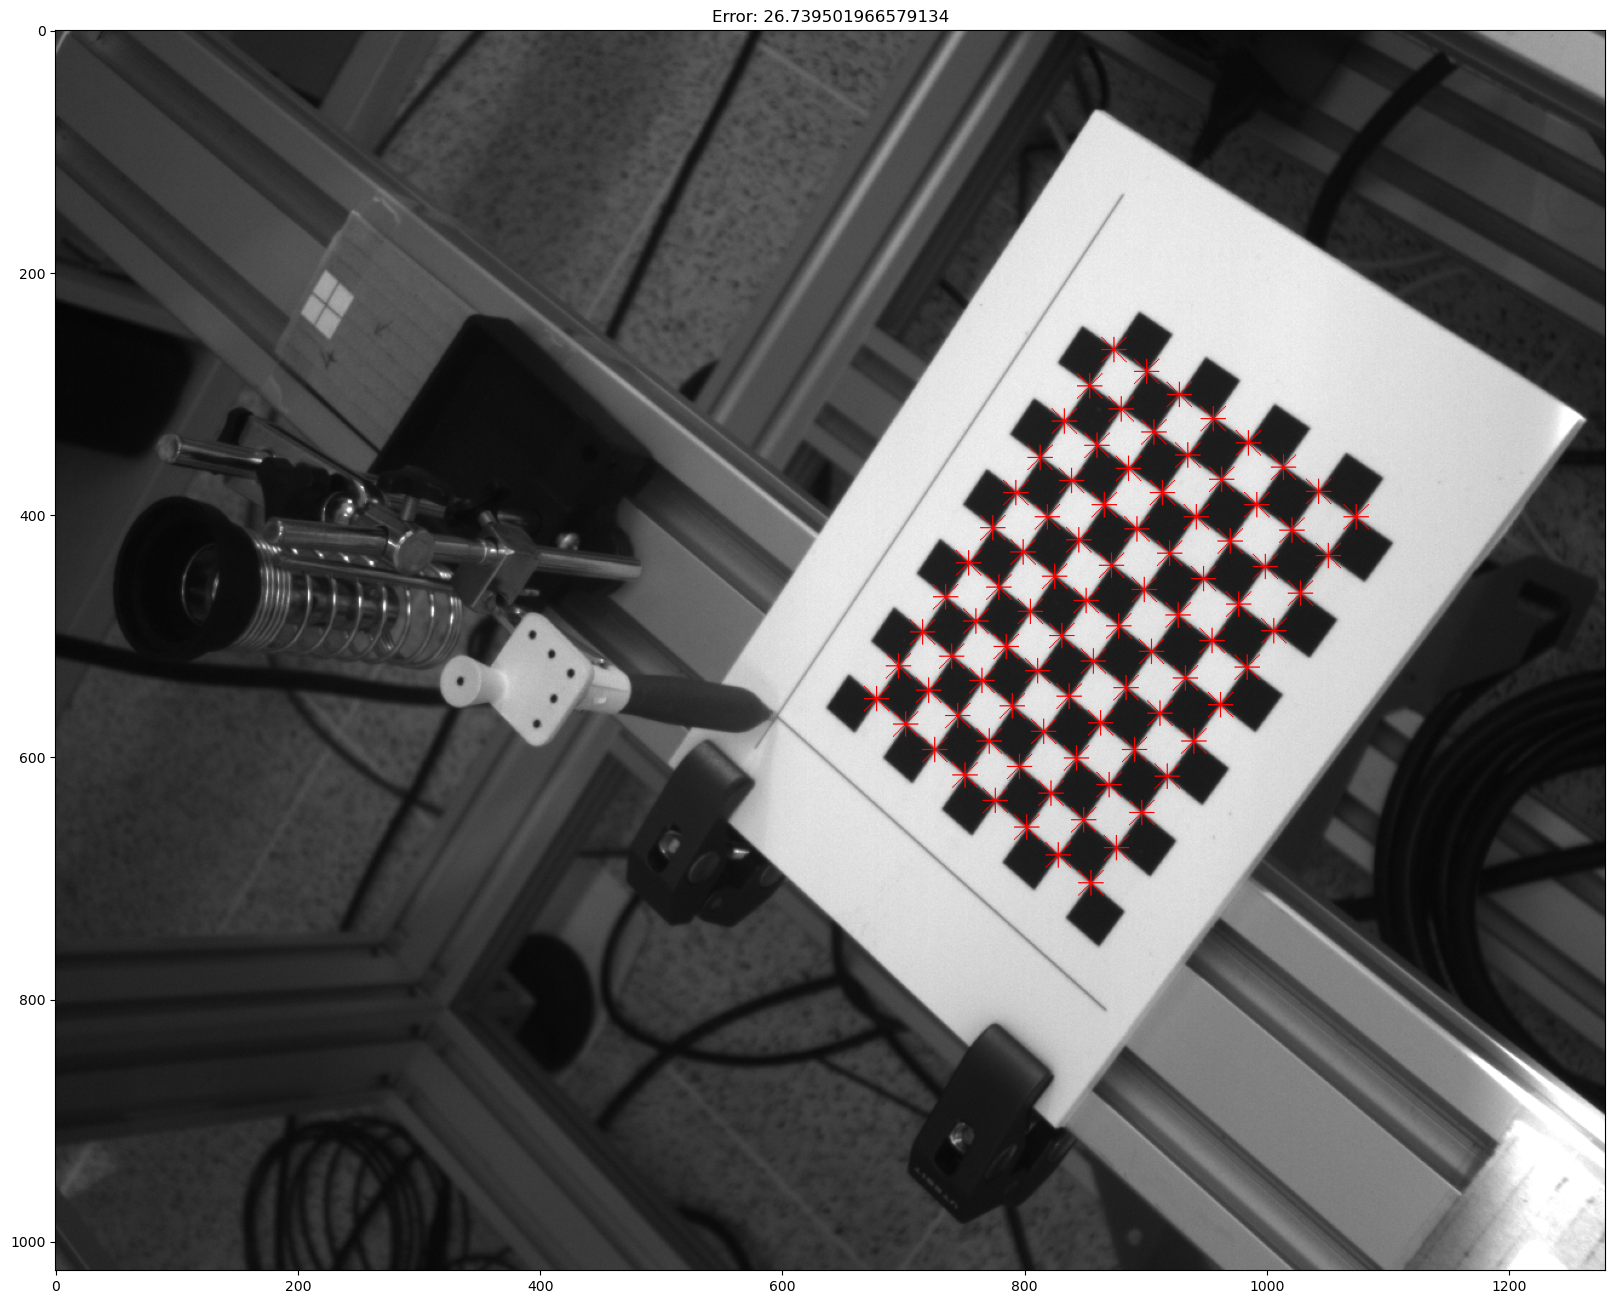

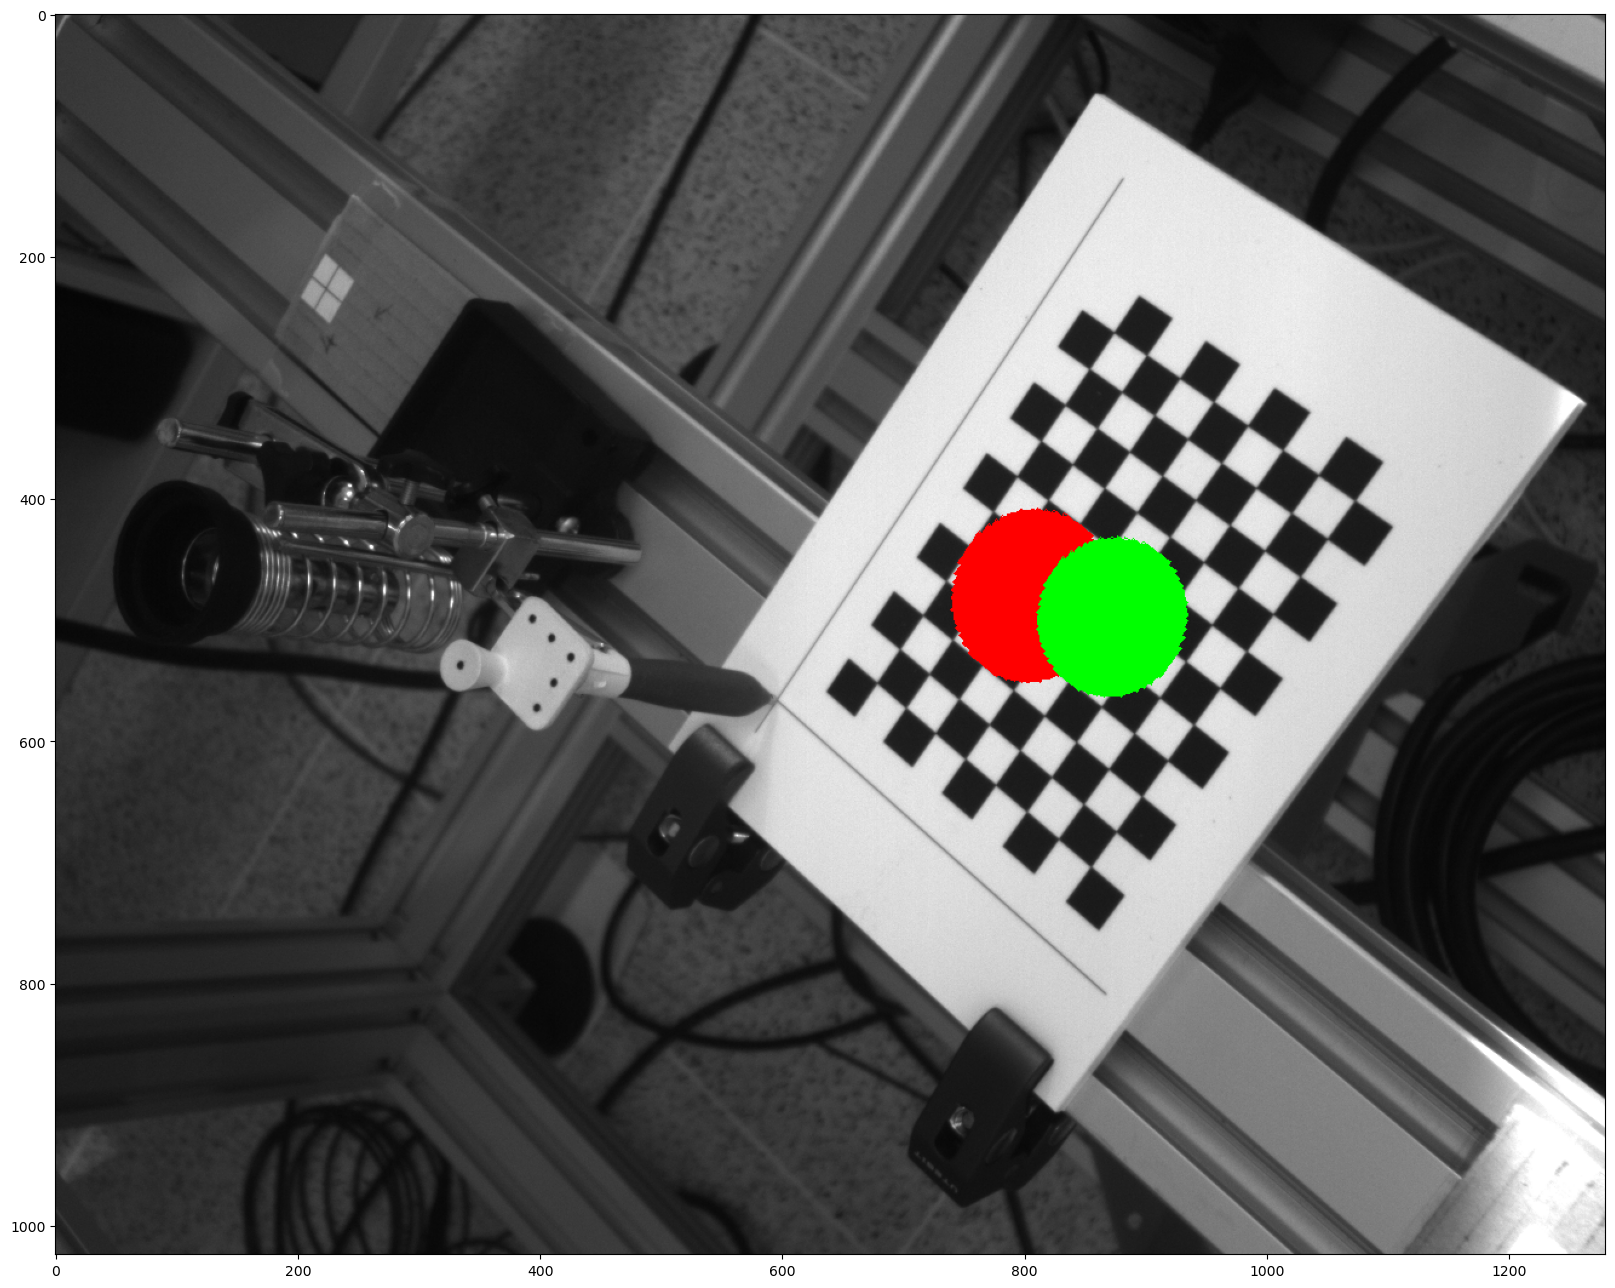

In [110]:
for i,path in enumerate([images_path[2]]):
    original = cv2.imread(path)
    H, R, I = calculate_homography(original)
    P = calculate_projection_matrix(H, K)
    error = reprojection_error(P, R, I)
    proj_chess = np.transpose(P@R.T)
    proj_chess[:,0] = proj_chess[:,0]/proj_chess[:,2]
    proj_chess[:,1] = proj_chess[:,1]/proj_chess[:,2]
    proj_chess = proj_chess[:,:-1]
    img1 = original.copy()
    for point in proj_chess:
        img1 = cv2.drawMarker(img1, tuple(np.array(point, dtype=np.int32)), (255,0,0), markerType=cv2.MARKER_STAR)
    
    proj_low = np.transpose(P @ pts_low.T)
    et_low[:,0] = proj_low[:,0]/proj_low[:,2]
    et_low[:,1] = proj_low[:,1]/proj_low[:,2]
    proj_high = np.transpose(P @ pts_high.T)
    et_high[:,0] = proj_high[:,0]/proj_high[:,2]
    et_high[:,1] = proj_high[:,1]/proj_high[:,2]
    print(proj_high)
    img2 = cv2.fillConvexPoly(original,np.array(et_low, dtype=np.int32),(255,0,0))
    img2 = cv2.fillConvexPoly(img2,np.array(et_high, dtype=np.int32),(0,255,0))
    plt.figure(figsize=(20,20))
    plt.imshow(img1)
    plt.title(f"Error: {error}")
    plt.figure(figsize=(20,20))
    plt.imshow(img2)